In [1]:
# Importação das bibliotecas
import requests 
from bs4 import BeautifulSoup 
import pandas as pd 
import re

In [2]:
# url das informações dos títulos.
url_fonte = 'http://www.tesouro.fazenda.gov.br/tesouro-direto-precos-e-taxas-dos-titulos'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36'}

In [3]:
# Conectando da página
con = requests.get(url_fonte, headers=headers)

In [4]:
# Status da Conexão. Status 200 conexão Ok.
#https://www.w3.org/Protocols/HTTP/1.1/draft-ietf-http-v11-spec-01#Status-Codes
con.status_code

200

In [5]:
# Cria objeto BeautifulSoup com o conteúdo html da página
soup = BeautifulSoup(con.content, "html.parser")
#print(soup.pretatify())

In [6]:
#Extraindo a tabela de Resgaste de Titulos
tabela_historico = soup.find('table', {'class': 'tabelaPrecoseTaxas sanfonado'}) 
#tabela_historico = soup.findAll('div', class_='sanfonado') 
#tabela_historico

In [7]:
# Extrai o conteúdo do corpo da  tabela.
body_tabela = tabela_historico.find('tbody')
#body_tabela
#type(body_tabela)

In [8]:
#head_tabela.find_all(class_='tittuloTabelaTesouroDireto')

In [9]:
#aa = head_tabela.find_all('th')
#aa

In [10]:
# Extrai as linhas do cabeçalho da tabela.
linhas_cabecalho_tabela = body_tabela.find_all('th')
cabecalho_tabela_tratada = []

for linha in linhas_cabecalho_tabela:
    cabecalho_tabela_tratada.append(linha.text.strip())

#cabecalho_tabela_tratada

In [11]:
#body_tabela.find_all('tr')

In [12]:
#body_tabela.find_all(class_='camposTesouroDireto')

In [13]:
# Extrai as linhas do restando corpo da tabela com os valores e descrições
#linhas_tabela = body_tabela.find_all('tr')
linhas_tabela = body_tabela.find_all(class_='camposTesouroDireto')
linhas_tabela_tratada = []

for linha in linhas_tabela:
    colunas=linha.find_all('td')
    colunas=[x.text.strip() for x in colunas]
    linhas_tabela_tratada.append(colunas)
    
#linhas_tabela_tratada


In [14]:
#Cria um dataframe com as linhas do corpo da tabela.
df_titulos = pd.DataFrame(linhas_tabela_tratada)
#df_titulos

In [15]:
#Adiciona o cabeçalho da tabela no dataframe criado.
df_titulos.columns = cabecalho_tabela_tratada

In [16]:
#Exibe as primeiras linha do dataframe
df_titulos.head()

,Título,Vencimento,Taxa de Rendimento (% a.a.),Preço Unitário
0,Tesouro IPCA+ 2019,15/05/2019,"1,64","R$3.162,12"
1,Tesouro IPCA+ 2024,15/08/2024,"4,26","R$2.527,43"
2,Tesouro IPCA+ 2035,15/05/2035,"4,60","R$1.533,84"
3,Tesouro IPCA+ 2045,15/05/2045,"4,60","R$979,50"
4,Tesouro IPCA+ com Juros Semestrais 2020,15/08/2020,"2,74","R$3.323,28"


In [17]:
#Verifica os tipos de dados antes as conversões.
df_titulos.dtypes

Título                         object
Vencimento                     object
Taxa de Rendimento (% a.a.)    object
Preço Unitário                 object
dtype: object

In [18]:
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

# Remove Simbolo de moeda
def removeSimboloMoeda(string):
     
    return string.strip().replace('R$','')

# Formata a exibição da moeda.
def formataMoeda(valor, exibeSimbolo=False):
    simbolo= None
    
    if exibeSimbolo:
        simbolo = 'C'
        
    return locale.currency(valor, grouping=True, symbol=simbolo)

#Invert o separador decimal.
def inverteSeparadorDecimal(string):
    string = str(string).replace(',','v')
    string = string.replace('.',',')
    string = string.replace('v','.')
    
    return string

#Converte um objeto para float
def objToFloat(obj):
   
    return  locale.atof(removeSimboloMoeda(obj))
    

#Trata o Volume
def trataVolume(vol):

    vol = str(vol).upper()
    k = vol.find('K')
    m = vol.find('M')

    valor=0

    if ( k > 0 ):
        valor = objToFloat(vol[0:k])
        valor = valor*1000
     
    elif ( m > 0 ):
        valor = objToFloat(vol[0:m])
        valor = valor*1000000
          
    return valor


#Trata o Variacao
def trataVariacao(var):
    
    var = str(var)
    k = var.find('%')
    
    valor=0

    if ( k > 0 ):
        valor = objToFloat(var[0:k])
        
    return valor

import time
import os

#Define a função que retorna os segundos no formato hh:mm:ss
def formata_segundos_hhmmss(segundos):
    return time.strftime('%H:%M:%S', time.gmtime(segundos))

#Define a função que retorna data atual do sistema.
def get_data_atual():
    return time.strftime("%d/%m/%Y")

#Define a função que retorna a data e hora atual do sistema.
def get_data_hora_atual():
    return time.strftime("%d/%m/%Y %H:%M:%S")

# Define a Função para Cria um diretório, se não existir
def cria_diretorio(path, recursivo=False):
    if not os.path.exists(path):
        if recursivo:
            os.makedirs(path)
        else:
            os.mkdir(path)

In [19]:
# Trata os tipos de dados das colunas

#Converta Coluna "Vencimento" para data
df_titulos['Vencimento'] = pd.to_datetime(df_titulos['Vencimento'])

# Converte Coluna "Taxa de Rendimento (% a.a.)" para Float
df_titulos['Taxa de Rendimento (% a.a.)'] = df_titulos['Taxa de Rendimento (% a.a.)'].apply(objToFloat)

# Converte Coluna "Preço Unitário" para Float
df_titulos['Preço Unitário'] = df_titulos['Preço Unitário'].apply(objToFloat)

# Adiciona a coluna "Data Hora Registro" que informa a data e hora da coleta dos dados.
df_titulos['Data Hora Registro'] =  pd.to_datetime( get_data_hora_atual())

In [20]:
#Verifica os tipos de dados após as conversões.
df_titulos.dtypes

Título                                 object
Vencimento                     datetime64[ns]
Taxa de Rendimento (% a.a.)           float64
Preço Unitário                        float64
Data Hora Registro             datetime64[ns]
dtype: object

In [21]:
# Visualizando o dataframe após as conversões.
df_titulos.head()

,Título,Vencimento,Taxa de Rendimento (% a.a.),Preço Unitário,Data Hora Registro
0,Tesouro IPCA+ 2019,2019-05-15,1.64,3162.12,2019-02-22 16:05:47
1,Tesouro IPCA+ 2024,2024-08-15,4.26,2527.43,2019-02-22 16:05:47
2,Tesouro IPCA+ 2035,2035-05-15,4.60,1533.84,2019-02-22 16:05:47
3,Tesouro IPCA+ 2045,2045-05-15,4.60,979.50,2019-02-22 16:05:47
4,Tesouro IPCA+ com Juros Semestrais 2020,2020-08-15,2.74,3323.28,2019-02-22 16:05:47


In [22]:
# Define a Titulo como indice do dataframe.
df_titulos.set_index('Título')

,Vencimento,Taxa de Rendimento (% a.a.),Preço Unitário,Data Hora Registro
Título,,,,
Tesouro IPCA+ 2019,2019-05-15,1.64,3162.12,2019-02-22 16:05:47
Tesouro IPCA+ 2024,2024-08-15,4.26,2527.43,2019-02-22 16:05:47
Tesouro IPCA+ 2035,2035-05-15,4.60,1533.84,2019-02-22 16:05:47
Tesouro IPCA+ 2045,2045-05-15,4.60,979.50,2019-02-22 16:05:47
Tesouro IPCA+ com Juros Semestrais 2020,2020-08-15,2.74,3323.28,2019-02-22 16:05:47
Tesouro IPCA+ com Juros Semestrais 2024,2024-08-15,4.18,3453.81,2019-02-22 16:05:47
Tesouro IPCA+ com Juros Semestrais 2026,2026-08-15,4.22,3530.58,2019-02-22 16:05:47
Tesouro IPCA+ com Juros Semestrais 2035,2035-05-15,4.49,3767.19,2019-02-22 16:05:47
Tesouro IPCA+ com Juros Semestrais 2045,2045-05-15,4.60,3892.35,2019-02-22 16:05:47


In [23]:
#Verifica os tipos de dados após as conversões.
df_titulos.dtypes

Título                                 object
Vencimento                     datetime64[ns]
Taxa de Rendimento (% a.a.)           float64
Preço Unitário                        float64
Data Hora Registro             datetime64[ns]
dtype: object

In [24]:
df_titulos.index.get_values()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24], dtype=int64)

In [25]:
# Dados da planilha que contém a carteira de títulos.
path_planilha_carteira = 'base_dados\\carteira_titulos_tesouro.xlsx'
nome_aba_carteira = 'MinhaCarteiraTitulosTesouro'

In [26]:
# Importa os títulos da carteira
df_carteira = pd.read_excel(path_planilha_carteira, sheet_name=nome_aba_carteira,header=1, usecols=[1,2,4,5,6,7,8,9] )
df_carteira

,Título,Data de vencimento,Preço para investimento (R$),Quantidade Compra,Data Compra,Valor Investido,Tipo,% Rentabilidade (a.a)
0,Tesouro Selic 2023,2023-03-01,9803.59,0.06,2018-11-12,587.9200,SELIC,0.0005
1,Tesouro Selic 2023,2023-03-01,9803.59,0.37,2018-11-13,3627.3283,SELIC,0.0005
2,Tesouro Selic 2023,2023-03-01,9803.59,0.08,2018-11-29,786.2200,SELIC,0.0005
3,Tesouro IPCA+ 2035,2035-05-15,1522.04,1.19,2019-01-15,1811.2200,IPCA,0.0459
4,Tesouro Selic 2023,2023-03-01,9903.19,0.19,2019-01-15,1881.6000,SELIC,0.0001
5,Tesouro IPCA+ 2035,2035-05-15,1567.14,2.32,2019-02-15,3635.7600,IPCA,0.0445
6,Tesouro Selic 2023,2035-05-15,9951.53,0.35,2019-02-15,3483.0300,SELIC,0.0002
7,Tesouro IPCA+ 2035,2035-05-15,1565.18,3.81,2019-02-18,5963.3300,IPCA,0.0446


In [27]:
#df_carteira.set_index(['Título','Data Compra'])
#df_carteira.set_index('Título')

In [28]:
# Faz o join dos dataframes
df_merge = pd.merge(df_carteira, df_titulos, on='Título', how='left')
#df_merge

In [29]:
#Remove as colunas que não serão usadas
df_merge = df_merge.drop(columns = ['Tipo','Data de vencimento', 'Data Hora Registro', 'Taxa de Rendimento (% a.a.)','% Rentabilidade (a.a)'])

In [30]:
# Renomeia algumas colunas do dataframe.
df_merge.rename(index=str, columns={'Preço Unitário': 'Preço Resgate', 'Preço para investimento (R$)': 'Preço Compra' }, inplace=True)

In [31]:
#Calcula a diferença entre o valor atual e valor pago
df_merge['Preço Resgate menos Compra'] = df_merge['Preço Resgate'] - df_merge['Preço Compra']

In [32]:
df_merge

,Título,Preço Compra,Quantidade Compra,Data Compra,Valor Investido,Vencimento,Preço Resgate,Preço Resgate menos Compra
0,Tesouro Selic 2023,9803.59,0.06,2018-11-12,587.9200,2023-01-03,9955.87,152.28
1,Tesouro Selic 2023,9803.59,0.37,2018-11-13,3627.3283,2023-01-03,9955.87,152.28
2,Tesouro Selic 2023,9803.59,0.08,2018-11-29,786.2200,2023-01-03,9955.87,152.28
3,Tesouro IPCA+ 2035,1522.04,1.19,2019-01-15,1811.2200,2035-05-15,1533.84,11.80
4,Tesouro Selic 2023,9903.19,0.19,2019-01-15,1881.6000,2023-01-03,9955.87,52.68
5,Tesouro IPCA+ 2035,1567.14,2.32,2019-02-15,3635.7600,2035-05-15,1533.84,-33.30
6,Tesouro Selic 2023,9951.53,0.35,2019-02-15,3483.0300,2023-01-03,9955.87,4.34
7,Tesouro IPCA+ 2035,1565.18,3.81,2019-02-18,5963.3300,2035-05-15,1533.84,-31.34


In [33]:
# Taxa do imposto de renda aplicado.
def getTaxaIRPF():
    return  22.5

#Calcula o rendimento bruto, ainda sem os descontos.
def calculaRendimentoBruto(precoResgate, quantidadeCompra, valoInvestido):
    return (precoResgate *  quantidadeCompra) - valoInvestido
  
# Calcula o valor IRPF que será descontado.
def calculaValorIRPF(rendimentoBruto, taxa_IRPF):
    return rendimentoBruto * taxa_IRPF

# Calcula o rendimento após o desconto do IRPF
def calculaRendimentoDescontadoIRPF(rendimentoBruto, valorIRPF):
    return rendimentoBruto - valorIRPF

# Calcula o % do redimento  após o desconto do IRPF
def calculaPercentualRendimentoDescontadoIRPF(rendimentoDescontadoIRPF, valorIvestido):
    return rendimentoDescontadoIRPF / valorIvestido

In [34]:
#Cria as colunas com os calculos de rendimentos
df_merge['Rendimento Bruto']  = df_merge.apply(lambda col: calculaRendimentoBruto(col['Preço Resgate'],col['Quantidade Compra'],col['Valor Investido']), axis=1)
df_merge['Valor IRPF (R$)'] = df_merge.apply(lambda col: calculaValorIRPF(col['Rendimento Bruto'],getTaxaIRPF()), axis=1)
df_merge['Rendimento descontado IRPF (R$)'] = df_merge.apply(lambda col: calculaRendimentoDescontadoIRPF(col['Rendimento Bruto'], col['Valor IRPF (R$)']), axis=1)
df_merge['Rendimento descontado IRPF %'] = df_merge.apply(lambda col: calculaPercentualRendimentoDescontadoIRPF(col['Rendimento descontado IRPF (R$)'] , col['Valor Investido']), axis=1)
df_merge

,Título,Preço Compra,Quantidade Compra,Data Compra,Valor Investido,Vencimento,Preço Resgate,Preço Resgate menos Compra,Rendimento Bruto,Valor IRPF (R$),Rendimento descontado IRPF (R$),Rendimento descontado IRPF %
0,Tesouro Selic 2023,9803.59,0.06,2018-11-12,587.9200,2023-01-03,9955.87,152.28,9.4322,212.22450,-202.79230,-0.344932
1,Tesouro Selic 2023,9803.59,0.37,2018-11-13,3627.3283,2023-01-03,9955.87,152.28,56.3436,1267.73100,-1211.38740,-0.333961
2,Tesouro Selic 2023,9803.59,0.08,2018-11-29,786.2200,2023-01-03,9955.87,152.28,10.2496,230.61600,-220.36640,-0.280286
3,Tesouro IPCA+ 2035,1522.04,1.19,2019-01-15,1811.2200,2035-05-15,1533.84,11.80,14.0496,316.11600,-302.06640,-0.166775
4,Tesouro Selic 2023,9903.19,0.19,2019-01-15,1881.6000,2023-01-03,9955.87,52.68,10.0153,225.34425,-215.32895,-0.114439
5,Tesouro IPCA+ 2035,1567.14,2.32,2019-02-15,3635.7600,2035-05-15,1533.84,-33.30,-77.2512,-1738.15200,1660.90080,0.456824
6,Tesouro Selic 2023,9951.53,0.35,2019-02-15,3483.0300,2023-01-03,9955.87,4.34,1.5245,34.30125,-32.77675,-0.009410
7,Tesouro IPCA+ 2035,1565.18,3.81,2019-02-18,5963.3300,2035-05-15,1533.84,-31.34,-119.3996,-2686.49100,2567.09140,0.430480


In [35]:
'''df_merge['Rendimento Bruto'] =  (df_merge['Preço Resgate'] *  df_merge['Quantidade Compra']) - df_merge['Valor Investido']
df_merge['Valor IRPF (R$)'] = df_merge['Rendimento Bruto'] * taxa_IRPF
df_merge['Rendimento descontado IRPF (R$)'] = df_merge['Rendimento Bruto'] - df_merge['Valor IRPF (R$)'] 
df_merge['Rendimento descontado IRPF %'] = df_merge['Rendimento descontado IRPF (R$)'] / df_merge['Valor Investido'] 
'''

"df_merge['Rendimento Bruto'] =  (df_merge['Preço Resgate'] *  df_merge['Quantidade Compra']) - df_merge['Valor Investido']\ndf_merge['Valor IRPF (R$)'] = df_merge['Rendimento Bruto'] * taxa_IRPF\ndf_merge['Rendimento descontado IRPF (R$)'] = df_merge['Rendimento Bruto'] - df_merge['Valor IRPF (R$)'] \ndf_merge['Rendimento descontado IRPF %'] = df_merge['Rendimento descontado IRPF (R$)'] / df_merge['Valor Investido'] \n"

In [54]:
df_merge.set_index('Título')

,Preço Compra,Quantidade Compra,Data Compra,Valor Investido,Vencimento,Preço Resgate,Preço Resgate menos Compra,Rendimento Bruto,Valor IRPF (R$),Rendimento descontado IRPF (R$),Rendimento descontado IRPF %
Título,,,,,,,,,,,
Tesouro Selic 2023,9803.59,0.06,2018-11-12,587.9200,2023-01-03,9955.87,152.28,9.4322,212.22450,-202.79230,-0.344932
Tesouro Selic 2023,9803.59,0.37,2018-11-13,3627.3283,2023-01-03,9955.87,152.28,56.3436,1267.73100,-1211.38740,-0.333961
Tesouro Selic 2023,9803.59,0.08,2018-11-29,786.2200,2023-01-03,9955.87,152.28,10.2496,230.61600,-220.36640,-0.280286
Tesouro IPCA+ 2035,1522.04,1.19,2019-01-15,1811.2200,2035-05-15,1533.84,11.80,14.0496,316.11600,-302.06640,-0.166775
Tesouro Selic 2023,9903.19,0.19,2019-01-15,1881.6000,2023-01-03,9955.87,52.68,10.0153,225.34425,-215.32895,-0.114439
Tesouro IPCA+ 2035,1567.14,2.32,2019-02-15,3635.7600,2035-05-15,1533.84,-33.30,-77.2512,-1738.15200,1660.90080,0.456824
Tesouro Selic 2023,9951.53,0.35,2019-02-15,3483.0300,2023-01-03,9955.87,4.34,1.5245,34.30125,-32.77675,-0.009410
Tesouro IPCA+ 2035,1565.18,3.81,2019-02-18,5963.3300,2035-05-15,1533.84,-31.34,-119.3996,-2686.49100,2567.09140,0.430480


In [55]:
df_final = df_merge.loc[df_merge['Título'] == 'Tesouro IPCA+ 2035']
df_final.set_index(['Título', 'Data Compra'])


Preço Compra  Quantidade Compra  \
Título             Data Compra                                    
Tesouro IPCA+ 2035 2019-01-15        1522.04               1.19   
                   2019-02-15        1567.14               2.32   
                   2019-02-18        1565.18               3.81   

                                Valor Investido Vencimento  Preço Resgate  \
Título             Data Compra                                              
Tesouro IPCA+ 2035 2019-01-15           1811.22 2035-05-15        1533.84   
                   2019-02-15           3635.76 2035-05-15        1533.84   
                   2019-02-18           5963.33 2035-05-15        1533.84   

                                Preço Resgate menos Compra  Rendimento Bruto  \
Título             Data Compra                                                 
Tesouro IPCA+ 2035 2019-01-15                        11.80           14.0496   
                   2019-02-15                       -33.30          -77.2512   
                   2019-02-18                       -31.34         -119.3996   

                                Valor IRPF (R$)  \
Título             Data Compra                    
Tesouro IPCA+ 2035 2019-01-15           316.116   
                   2019-02-15         -1738.152   
                   2019-02-18         -2686.491   

                                Rendimento descontado IRPF (R$)  \
Título             Data Compra                                    
Tesouro IPCA+ 2035 2019-01-15                         -302.0664   
                   2019-02-15                         1660.9008   
                   2019-02-18                         2567.0914   

                                Rendimento descontado IRPF %  
Título             Data Compra                                
Tesouro IPCA+ 2035 2019-01-15                      -0.166775  
                   2019-02-15                       0.456824  
                   2019-02-18                       0.430480

In [56]:
import matplotlib.pyplot as plt

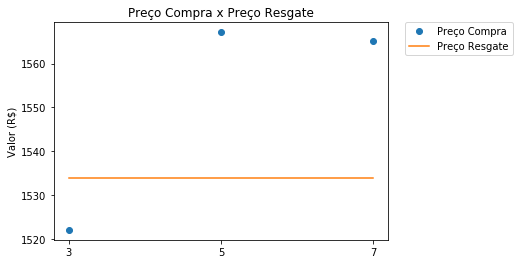

In [57]:
plt.title('Preço Compra x Preço Resgate')
plt.plot(df_final['Preço Compra'], 'o')
plt.plot(df_final['Preço Resgate'], )
plt.ylabel('Valor (R$)')
#plt.xlabel('Qtd')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [58]:
taxaRendimento = 1.0
valorDiferenca = 1.0

df_selecao_final = df_final[ (df_final['Rendimento descontado IRPF %'] > taxaRendimento) & ( df_final['Preço Resgate menos Compra'] > valorDiferenca) ]
df_selecao_final

,Título,Preço Compra,Quantidade Compra,Data Compra,Valor Investido,Vencimento,Preço Resgate,Preço Resgate menos Compra,Rendimento Bruto,Valor IRPF (R$),Rendimento descontado IRPF (R$),Rendimento descontado IRPF %


In [59]:
lista_msgs = []

for index, row  in df_selecao_final.iterrows() : 
    nomeTitulo = row['Título']
    dataCompra = row['Data Compra']
    percRendimentodescontadoIRPF = row['Rendimento descontado IRPF %']
    valorRendimentodescontadoIRPF =row['Rendimento descontado IRPF (R$)']
    valorAtual = row['Preço Resgate']
    valorCompra =  row['Preço Compra']
    redimentoBruto = row['Rendimento Bruto']
    valorInvestido =  row['Valor Investido']
    
    mensagem = 'O título {0} comprado em {1:%d/%m/%Y} atingiu o % de Rendimento (descontado IRPF): {2:.2f}%. O Valor do Rendimento (descontado IRPF): R$ {3:.2f}. Valor atual: R$ {4:.2f}. Valor de compra: R$ {5:.2f}. Redimento Bruto: R$ {6:.2f}. Valor investido R$ {7:.2f} \n'.format( nomeTitulo, dataCompra ,percRendimentodescontadoIRPF,valorRendimentodescontadoIRPF, valorAtual, valorCompra, redimentoBruto, valorInvestido)
    
    lista_msgs.append(mensagem)

In [60]:
import telegram_send     

In [61]:
for msg in lista_msgs:
    #telegram_send.send(messages=[msg])
    print(msg)